# GenTestJig - Mechanics

## Dependencies

- openscad CLI
- 

## Get PCB size

In [9]:
import struct
from pathlib import Path

def stl_bounds(path):
    path = Path(path)
    data = path.read_bytes()

    # Try binary STL first
    if len(data) >= 84:
        tri_count = struct.unpack("<I", data[80:84])[0]
        expected = 84 + tri_count * 50
        if expected == len(data):
            mins = [float("inf")] * 3
            maxs = [float("-inf")] * 3
            off = 84
            for _ in range(tri_count):
                off += 12  # skip normal
                for _ in range(3):
                    x, y, z = struct.unpack("<fff", data[off:off+12])
                    mins[0] = min(mins[0], x); maxs[0] = max(maxs[0], x)
                    mins[1] = min(mins[1], y); maxs[1] = max(maxs[1], y)
                    mins[2] = min(mins[2], z); maxs[2] = max(maxs[2], z)
                    off += 12
                off += 2
            return tuple(mins), tuple(maxs)

    # Fallback: ASCII STL
    mins = [float("inf")] * 3
    maxs = [float("-inf")] * 3
    for line in data.decode("utf-8", errors="ignore").splitlines():
        s = line.strip()
        if s.startswith("vertex"):
            _, xs, ys, zs = s.split()
            x, y, z = float(xs), float(ys), float(zs)
            mins[0] = min(mins[0], x); maxs[0] = max(maxs[0], x)
            mins[1] = min(mins[1], y); maxs[1] = max(maxs[1], y)
            mins[2] = min(mins[2], z); maxs[2] = max(maxs[2], z)
    return tuple(mins), tuple(maxs)

project_dir = Path("Mechanics") if Path("Mechanics").exists() else Path.cwd()
pcb_stl = project_dir / "pcb" / "24-clocks.stl"
params_scad = project_dir / "params.scad"

mins, maxs = stl_bounds(pcb_stl)
params = {
    "pcb_min_x": mins[0],
    "pcb_max_x": maxs[0],
    "pcb_min_y": mins[1],
    "pcb_max_y": maxs[1],
    "pcb_min_z": mins[2],
    "pcb_max_z": maxs[2],
}

with params_scad.open("w", encoding="utf-8") as f:
    f.write("// Auto-generated from pcb/24-clocks.stl bounds.\n")
    for key, value in params.items():
        f.write(f"{key} = {value:.6f};\n")

print("PCB bounds:")
for axis, i in [("X", 0), ("Y", 1), ("Z", 2)]:
    print(f"{axis}: min={mins[i]:.6f}, max={maxs[i]:.6f}")
print(f"Wrote {params_scad}")


PCB bounds:
X: min=103.000000, max=197.000000
Y: min=-142.000000, max=-65.000000
Z: min=-5.085000, max=10.141200
Wrote c:\Users\mvl\GitPrive\GenTestJig\Mechanics\params.scad


## Extract test points


In [10]:
import csv
from pathlib import Path

project_dir = Path("Mechanics") if Path("Mechanics").exists() else Path.cwd()
csv_path = project_dir / "pcb" / "24-clocks-testpoints.csv"
params_scad = project_dir / "params.scad"

if not csv_path.exists():
    raise FileNotFoundError(f"Missing CSV file: {csv_path}")
if not params_scad.exists():
    raise FileNotFoundError(f"Missing params file: {params_scad}. Run the bounds cell first.")

points = []
with csv_path.open(newline="", encoding="utf-8-sig") as f:
    reader = csv.DictReader(f)
    cols = {c.strip().lower(): c for c in (reader.fieldnames or [])}
    if "x" not in cols or "y" not in cols:
        raise ValueError(f"CSV must contain x and y columns. Found: {reader.fieldnames}")

    x_col = cols["x"]
    y_col = cols["y"]
    for row in reader:
        x_raw = (row.get(x_col) or "").strip()
        y_raw = (row.get(y_col) or "").strip()
        if not x_raw or not y_raw:
            continue
        points.append((float(x_raw), float(y_raw)))

if not points:
    raise ValueError("No valid x/y testpoints found in CSV.")

list_body = ", ".join(f"[{x:.6f}, {y:.6f}]" for x, y in points)
line = f"pcb_testpoints_xy = [{list_body}];\n"

existing = params_scad.read_text(encoding="utf-8")
lines = [ln for ln in existing.splitlines() if not ln.strip().startswith("pcb_testpoints_xy")]
updated = ("\n".join(lines).rstrip() + "\n" + line)
params_scad.write_text(updated, encoding="utf-8")

print(f"Parsed {len(points)} testpoints from {csv_path.name}")
print(f"Updated {params_scad}")


Parsed 53 testpoints from 24-clocks-testpoints.csv
Updated c:\Users\mvl\GitPrive\GenTestJig\Mechanics\params.scad


## Extract center pins


In [12]:
import math
from pathlib import Path

project_dir = Path("Mechanics") if Path("Mechanics").exists() else Path.cwd()
drl_path = project_dir / "pcb" / "24-clocks_NPTH_drill.drl"
params_scad = project_dir / "params.scad"

if not drl_path.exists():
    raise FileNotFoundError(f"Missing drill file: {drl_path}")
if not params_scad.exists():
    raise FileNotFoundError(f"Missing params file: {params_scad}. Run previous cells first.")

lines = drl_path.read_text(encoding="utf-8", errors="ignore").splitlines()

units = None
tool_diam_mm = {}
active_tool = None
holes_by_tool = {}

for raw in lines:
    line = raw.strip()
    if not line or line.startswith(";"):
        continue

    if line == "INCH":
        units = "INCH"
        continue
    if line == "METRIC":
        units = "METRIC"
        continue

    if line.startswith("T") and "C" in line:
        t, c = line.split("C", 1)
        tool = t.strip()
        diam = float(c.strip())
        if units == "INCH":
            diam *= 25.4
        tool_diam_mm[tool] = diam
        continue

    if line.startswith("T") and line[1:].isdigit():
        active_tool = line
        holes_by_tool.setdefault(active_tool, [])
        continue

    if line.startswith("X") and "Y" in line and active_tool:
        x_part, y_part = line[1:].split("Y", 1)
        x = float(x_part)
        y = float(y_part)
        if units == "INCH":
            x *= 25.4
            y *= 25.4
        holes_by_tool[active_tool].append((x, y))

if units is None:
    raise ValueError("Could not determine drill units (INCH/METRIC).")

target_tools = [t for t, d in tool_diam_mm.items() if abs(d - 3.2) <= 0.15]
if not target_tools:
    raise ValueError(f"No ~3.2 mm tools found. Tools (mm): {tool_diam_mm}")

holes = []
for t in target_tools:
    holes.extend(holes_by_tool.get(t, []))

if len(holes) < 2:
    raise ValueError(f"Need at least 2 candidate holes, found {len(holes)}")

best = None
best_d2 = -1.0
for i in range(len(holes)):
    x1, y1 = holes[i]
    for j in range(i + 1, len(holes)):
        x2, y2 = holes[j]
        d2 = (x2 - x1) ** 2 + (y2 - y1) ** 2
        if d2 > best_d2:
            best_d2 = d2
            best = ((x1, y1), (x2, y2))

(p1, p2) = best
(x1, y1), (x2, y2) = p1, p2

updates = [
    f"pcb_center_pin_1_x = {x1:.6f};",
    f"pcb_center_pin_1_y = {y1:.6f};",
    f"pcb_center_pin_2_x = {x2:.6f};",
    f"pcb_center_pin_2_y = {y2:.6f};",
    f"pcb_center_pins_xy = [[{x1:.6f}, {y1:.6f}], [{x2:.6f}, {y2:.6f}]];",
]

existing = params_scad.read_text(encoding="utf-8")
prefixes = (
    "pcb_center_pin_1_x",
    "pcb_center_pin_1_y",
    "pcb_center_pin_2_x",
    "pcb_center_pin_2_y",
    "pcb_center_pins_xy",
)
filtered = [ln for ln in existing.splitlines() if not ln.strip().startswith(prefixes)]
updated = ("\n".join(filtered).rstrip() + "\n" + "\n".join(updates) + "\n")
params_scad.write_text(updated, encoding="utf-8")

print(f"3.2 mm tools: {target_tools}")
print(f"Selected holes: ({x1:.6f}, {y1:.6f}) and ({x2:.6f}, {y2:.6f})")
print(f"Distance: {math.sqrt(best_d2):.6f} mm")
print(f"Updated {params_scad}")


3.2 mm tools: ['T3']
Selected holes: (131.000500, -138.000740) and (182.001160, -72.499220)
Distance: 83.015158 mm
Updated c:\Users\mvl\GitPrive\GenTestJig\Mechanics\params.scad


## Render parts

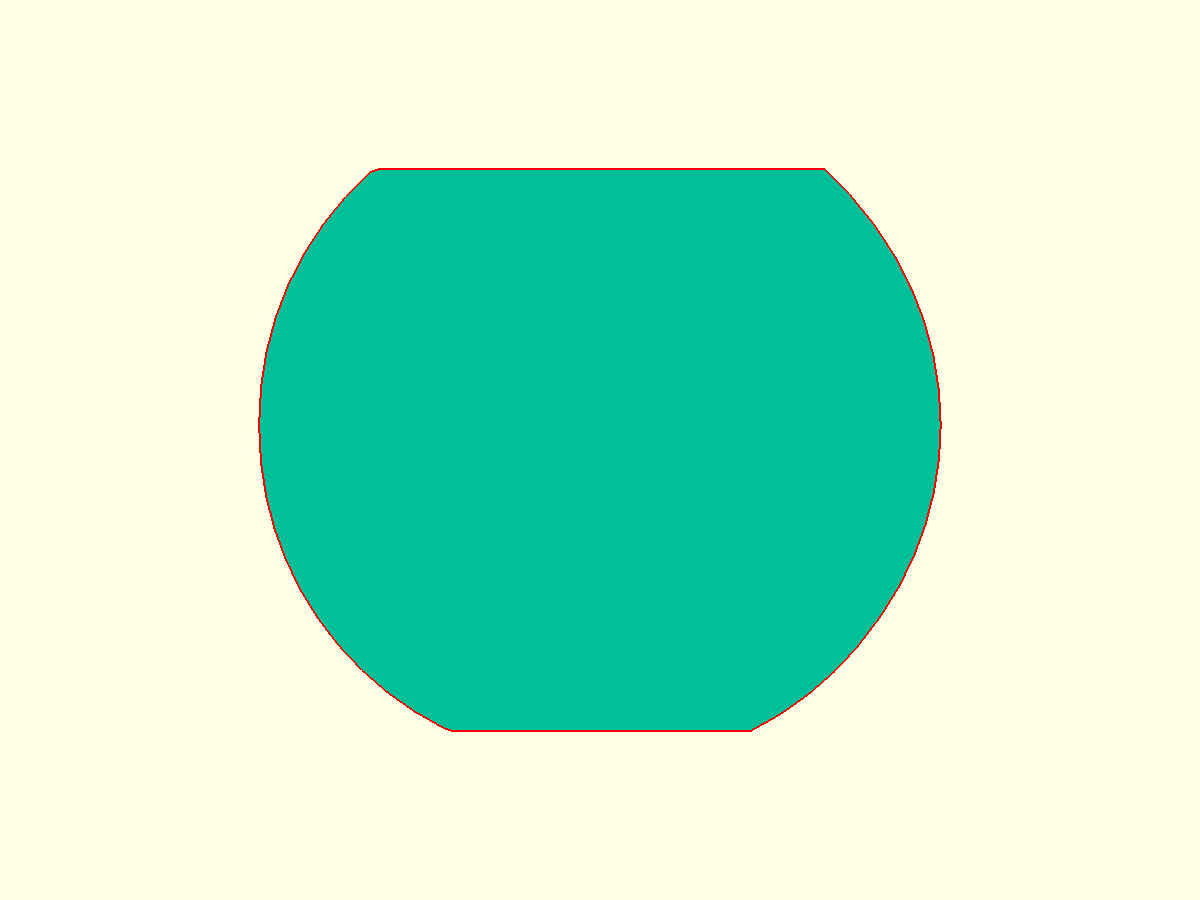

In [8]:
import subprocess, pathlib, shutil, textwrap
from IPython.display import Image, display

project_dir = pathlib.Path("Mechanics") if pathlib.Path("Mechanics").exists() else pathlib.Path.cwd()
tester_scad = project_dir / "Tester test.scad"
pcb_stl = project_dir / "pcb" / "24-clocks.stl"
wrapper_scad = project_dir / "pcb_border_preview.scad"
preview_png = project_dir / "pcb_border_top.png"

default_macos_openscad = pathlib.Path("/Applications/OpenSCAD.app/Contents/MacOS/OpenSCAD")
openscad_bin = shutil.which("openscad") or (str(default_macos_openscad) if default_macos_openscad.exists() else None)
if not openscad_bin:
    raise FileNotFoundError(
        "OpenSCAD CLI not found. Install OpenSCAD and add `openscad` to PATH, "
        "or set openscad_bin to /Applications/OpenSCAD.app/Contents/MacOS/OpenSCAD on macOS."
    )

if not tester_scad.exists():
    raise FileNotFoundError(f"Missing SCAD file: {tester_scad}")
if not pcb_stl.exists():
    raise FileNotFoundError(f"Missing STL file: {pcb_stl}")

wrapper_scad.write_text(textwrap.dedent("""\
use <Tester test.scad>;

pcb = \"pcb/24-clocks.stl\";
clearancePcbEdge = 0.5;

// Render 2D border directly in the XY plane (X horizontal, Y vertical).
pcbBorder(pcb);
"""))

subprocess.run(
    [
        openscad_bin,
        "--render",
        "--projection=o",
        "--camera=0,0,0,0,0,0,500",
        "--viewall",
        "--autocenter",
        "--imgsize=1200,900",
        "-o",
        str(preview_png),
        str(wrapper_scad),
    ],
    check=True,
)
display(Image(str(preview_png)))
